# __Cost of Education in Republican vs Democrat leaning US States__

### Group 15: Alice Le, Jitao Zhang, Lincoln Lee, Yitong Gong

## __1. Introduction__

Post-secondary education is an important and often necessary step in the desired career paths of many students in the USA. The cost to attend, however, is often a prohibiting factor. With fair variance in the cost of attendance between schools in different states, it's fairly common to see students move across the country to attend school where it is more affordable. As a result, tuition costs has long been a point of contention in the US political arena, and a central talking point in presidential elections. But for all of the talking and debating that occurs in TV and during campaigns, are schools in Democrat or Republican leaning areas actually cheaper or more expensive to attend?

In other words, we are interested in **assessing whether there is a statistically significant difference between the average tuition cost in Republican-leaning states and Democrat-leaning states.**

We will investigate this using hypothesis testing on the difference of two population means, and also investigate the standard deviation of the difference in means to produce a confidence interval.

## __2. Methods and Results__ 

### 2.1 Setup & Wrangling the Data

Let's start by importing all necessary libraries, the dataset from our online source, and setting some basic formatting for our graphs.

In [29]:
# All needed libraries
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)

# General graph formatting settings
options(repr.plot.width = 10, repr.plot.height = 6)

# Import online dataset
original_dataset <- read_csv("https://raw.githubusercontent.com/Jitao-Z/dataset/main/nces330_20.csv")
head(original_dataset)

Rows: 3548 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): State, Type, Length, Expense
dbl (2): Year, Value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Year,State,Type,Length,Expense,Value
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
2013,Alabama,Private,4-year,Fees/Tuition,13983
2013,Alabama,Private,4-year,Room/Board,8503
2013,Alabama,Public In-State,2-year,Fees/Tuition,4048
2013,Alabama,Public In-State,4-year,Fees/Tuition,8073
2013,Alabama,Public In-State,4-year,Room/Board,8473
2013,Alabama,Public Out-of-State,2-year,Fees/Tuition,7736


__2.1.1 Cleaning the data__

The dataset also contains information regarding miscellaneous student costs such as books and living costs. Further, as we are using the 2020 presidential election as a gauge for the political leaning of each state, we want to rely on the data from 2020 only to avoid including data from when the political landscape may have been different.

Let's filter for just the data we're interested in: student tuition in 2020.

In [30]:
set.seed(2356)

# filters out all the irrelevant columns
tuition <- original_dataset |>
    filter(!is.na(Value),
           Expense == "Fees/Tuition",
           Year == 2020)

Now, we want to group the data by state to find the average cost of tuition in that state. That gives us a data table with two columns: state, and average tuition.

To correlate the average tuitions to a political leaning, we append a `political_leaning` column to each row, indicating the 2020 presidential election result for each state.

In [31]:
# calculates the mean tuition fee for each state in 2020
# mean_tuition_fee represents the average tuition fee for each state in 2020
tuition <- tuition |>
    group_by(State) |>
    summarize(mean_tuition_fees = mean(Value))


# adds the third column of political leaning
# note that we are using the party affiliation of each state in the 2020 presidential election 
# to represent their political leanings 
# demo stands for democrat; repub stands for republican
tuition <- tuition |>
    mutate(political_leaning = as.factor(ifelse(grepl("Arizona|California|Colorado|Connecticut|Delaware|Georgia|Hawaii
                                                |Illinois|Maine|Maryland|Massachusetts|Michigan|Minnesota
                                                |Nevada|New Hampshire|New Jersey|New Mexico|New York|Oregon
                                                |Pennsylvania|Rhode Island|Vermont|Virginia|Washington|Wisconsin", State), 
                                            "demo", "repub")))

head(tuition)
nrow(tuition |> filter(political_leaning == "demo"))
nrow(tuition |> filter(political_leaning == "repub"))

State,mean_tuition_fees,political_leaning
<chr>,<dbl>,<fct>
Alabama,13628.80,repub
Alaska,18248.67,repub
Arizona,12235.40,demo
Arkansas,12422.00,repub
California,17368.40,demo
Colorado,14833.20,demo


[1] 23

[1] 28

### 2.2 Initial Impressions

__2.2.1 Visualization of the initial data__

Before we dive into the full analysis, let's use compare the simple sample averages to get a glimpse into the data. We'll use two boxplots side-by-side showing the average tuition fees of schools in democrat and republican-leaning states in 2020.

Note that the boxplot **will almost certainly not** reflect the true population parameters due to sampling variability. It just gives us some insights into what our dataset looks like and facilitate some first guesses in the difference of mean tuition fees between democrat and republican states.

##### Figure 1: Boxplots for tuition fees of democrat and republican states in 2020

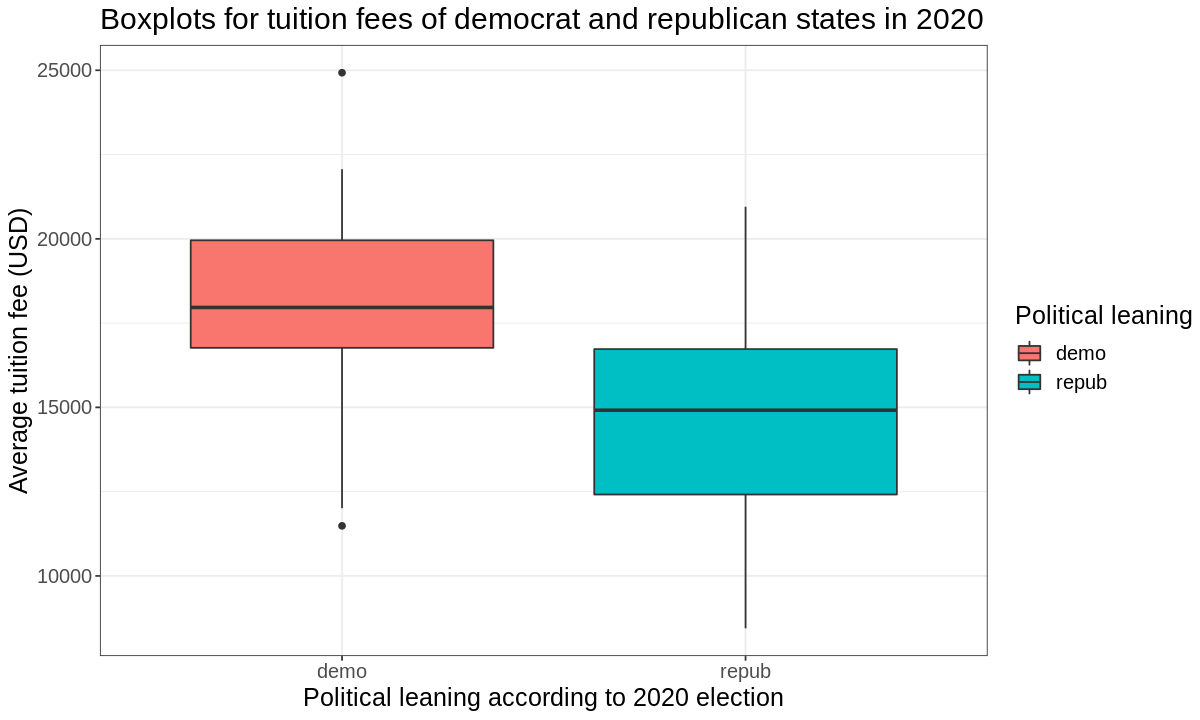

In [32]:
tuition_boxplots <- tuition |>
    ggplot(mapping = aes(x = political_leaning, y = mean_tuition_fees, fill = political_leaning)) +
    geom_boxplot() +
    ggtitle("Boxplots for tuition fees of democrat and republican states in 2020") +
    labs(x = "Political leaning according to 2020 election", y = "Average tuition fee (USD)", fill = "Political leaning") +
    theme_bw() +
    theme(text = element_text(size = 15))

tuition_boxplots

__2.2.2 Computation of estimate of the parameter__

Let's now take a closer look at the **difference** of these two simple means, starting with some variable definitions.

- $\mu_1$: population mean of tuition fees of democrat states in 2020
- $\mu_2$: population mean of tuition fees of republican states in 2020

- $\bar{x_1}$: sample mean of tuition fees of democrat states in 2020
- $\bar{x_2}$: sample mean of tuition fees of republican states in 2020

The difference of the two sample means, $\bar{x_1} - \bar{x_2}$, is used as our estimate to approximate $\mu_1 - \mu_2$, our parameter of interest. Again, this is just meant as a first glimpse into the data.

##### Table 1: Difference between two sample means

In [34]:
summary <- tuition |>
    group_by(political_leaning) |>
    summarize(mean = mean(mean_tuition_fees))

# diff represents demo - repub
estimates <- data.frame(x1_bar = summary$mean[1],
                        x2_bar = summary$mean[2]) |>
    mutate(diff = x1_bar - x2_bar)

estimates

x1_bar,x2_bar,diff
<dbl>,<dbl>,<dbl>
17996.75,14564.99,3431.759


Our initial rough guess says the difference between the two samples means is **3431.759 USD**, suggesting that it is that much cheaper to attend school in a Republican-leaning state (though again, we will need to conduct a more thorough analysis for a concrete estimate)

### 2.3 Starting our Thorough Investigation

<font color="#940000">We've been saying like a broken record that the above analysis is not sufficient. Lets now dive into the proper analysis using <b>both a hypothesis test and confidence interval</b> to further verify or repudiate our initial guess.</font>

__2.3.1 Hypothesis testing and Confidence Interval__

Before we get started, let's first review our parameters, statistics, and hypotheses.

- $\mu_1$: population mean of tuition fees of democrat states in 2020
- $\mu_2$: population mean of tuition fees of republican states in 2020

- $\bar{x_1}$: sample mean of tuition fees of democrat states in 2020
- $\bar{x_2}$: sample mean of tuition fees of republican states in 2020

- <mark>$H_0: \mu_1 - \mu_2 = 0$<mark>
- <mark>$H_1: \mu_1 - \mu_2 > 0$<mark>

Our null hypothesis, or what we will conclude if there is no sufficient evidence otherwise, is that there is no difference between the average tuitions between schools in republican and democrat states. Our alternative hypothesis is that democrat state schools are more expensive than republican states, according to our initial guesses above.

Since we don't know our population standard deviations, we will use sample standard deviations as approximations to conduct a __2-sample t-test__ in the following process. After that, we will do another bootstrapping to compare the results obtained from these two methods.

Moreover, we will fix our __significance level__ $\alpha$ to be $5\%$ (obtain the 95% confidence interval).

### 2.4 Theory-based Hypothesis Test & Confidence Interval

__2.4.1 Theory-based hypothesis test__

In [35]:
head(tuition)

State,mean_tuition_fees,political_leaning
<chr>,<dbl>,<fct>
Alabama,13628.80,repub
Alaska,18248.67,repub
Arizona,12235.40,demo
Arkansas,12422.00,repub
California,17368.40,demo
Colorado,14833.20,demo


To start, we will obtain all the variables we need to know to calculate our test statistic.

##### Table 2: Summary of all variables required to calculate the test statistic

In [36]:
tuition_summary_table <- tuition |>
    group_by(political_leaning) |>
    summarize(sample_mean = mean(mean_tuition_fees),
              sample_var = var(mean_tuition_fees),
              n = n())

tuition_summary_table

political_leaning,sample_mean,sample_var,n
<fct>,<dbl>,<dbl>,<int>
demo,17996.75,11465888,23
repub,14564.99,9532268,28


Based on the information we obtained from the above table, we can calculate the test statistic using the following formula:

$$
T = \frac{\bar{x}_{\text{Democrat}} - \bar{x}_{\text{Republican}}}{\sqrt{\frac{s^2_{\text{Democrat}}}{n_1}+\frac{s^2_{\text{Republican}}}{n_2}}}
$$

In [37]:
test_statistic <- (tuition_summary_table$sample_mean[1] - tuition_summary_table$sample_mean[2]) / 
                   sqrt(tuition_summary_table$sample_var[1]/tuition_summary_table$n[1] + tuition_summary_table$sample_var[2]/tuition_summary_table$n[2])
test_statistic

[1] 3.746687

Next, we need to identify our degrees of freedom to be used in the hypothesis test. For our two-sample t-test, we will use the Welch-Satterthwaite method to approximate the degrees of freedom.
$$
df = n_{\text{Smaller}} - 1
$$

In [79]:
df <- 23 - 1
df

[1] 22

Next, we can obtain the p-value for this hypothesis test under the assumption that $H_0$ is true.

In [80]:
p_value <- 1 - pt(test_statistic, df)

p_value

[1] 0.0005582374

Since our p-value is much smaller than our stated significance level (0.00056 < 0.05), we will <mark>reject our null hypothesis<mark>.
This also obeys our initial guess: it is much more expensive to attend school in a Democrat-leaning state.

__2.4.2 Theory-based confidence interval__<br/>
Let's also use the Theory-based method to construct a 95% confidence interval.

##### Table 3: Confidence interval calculated by the Theory-based method

In [81]:
critical_value <- qt(0.5 + 0.95/2, df)
standard_error <- sqrt(tuition_summary_table$sample_var[1]/tuition_summary_table$n[1] + tuition_summary_table$sample_var[2]/tuition_summary_table$n[2])

confidence_interval <- tibble(
    lower_ci = (tuition_summary_table$sample_mean[1] - tuition_summary_table$sample_mean[2]) - critical_value * standard_error,
    upper_ci = (tuition_summary_table$sample_mean[1] - tuition_summary_table$sample_mean[2]) + critical_value * standard_error)

confidence_interval

lower_ci,upper_ci
<dbl>,<dbl>
1532.206,5331.313


According to this confidence interval, we are <mark>95% confident</mark> that the actual parameter of interest, $\mu_1 - \mu_2$, is <mark>between 1532.206 USD and 5331.313 USD</mark>.

### 2.5 Bootstrapping-based Hypothesis Test & Confidence Interval

__2.5.1 Bootstrapping hypothesis test__

Let's have a look at our data again.

In [82]:
head(tuition)

State,mean_tuition_fees,political_leaning
<chr>,<dbl>,<fct>
Alabama,13628.80,repub
Alaska,18248.67,repub
Arizona,12235.40,demo
Arkansas,12422.00,repub
California,17368.40,demo
Colorado,14833.20,demo


There are many ways to compute the bootstrap samples for our hypothesis testing, for our convenience, we will be using the __infer__ package's workflow. 

<br> 1. `set.seed(1)` First we need to set the seed to ensure that our model is __reproducible__.

2.`specify()` Next, we will __specify__ the response variable (mean_tuition_fees) and explanatory variable(political_leaning).

3.`hypothesize()` Since our hypothesis test invoved  two independent samples, our null argument will be set to `independence`.

4.`generate()` We are going to generate __2000__ samples the same size as our original sample without replacement with `permute`. Note: Large resamples such as 2000 are computationally expensive, however, we believe that 2000 resamples are large enough to get a good estimate of the population parameter. 
<br>
<br>
5. `calculate()` Last but not least, we want our test statistics to be __diff in means__ since we are looking for the difference between the tuition of Democratic states institutions and the Republican states institutions specifically in this order

In [83]:
set.seed(1)

diff_in_means <- tuition |>
    specify(mean_tuition_fees ~ political_leaning) %>%
    hypothesize(null = "independence") %>% 
    generate(reps = 2000, type = "permute") %>% 
    calculate(stat= "diff in means", order = c("demo", "repub"))

head(diff_in_means)

replicate,stat
<int>,<dbl>
1,429.02195
2,465.29081
3,195.18747
4,45.66667
5,662.42746
6,1917.77187


Now, let's get the p-value for our test.
- We are getting the observed statistics from the computed difference from our initial impressions section __2.2__.
- Our alternative hypothesis is $H_1: \mu_1 - \mu_2 > 0$, hence, the direction we want to obtain is to the __right__ side.

In [84]:
set.seed(1)
bootstrap_pvalue <- diff_in_means |>
    get_p_value(obs_stat = estimates$diff, direction = "right")

bootstrap_pvalue

p_value
<dbl>
5e-04


Let's also get the 95th quantile, to represent the boundary of the rejection region on the bootstrap distribution.

In [119]:
quantile975 <- diff_in_means %>%
    select(stat) %>%
    pull(stat) %>%
    quantile(0.95)

quantile975

95% 
1645.329

Now, lets put both the rejection region and the observed test statistic to see if the test statistic provides evidence against the null hypothesis.

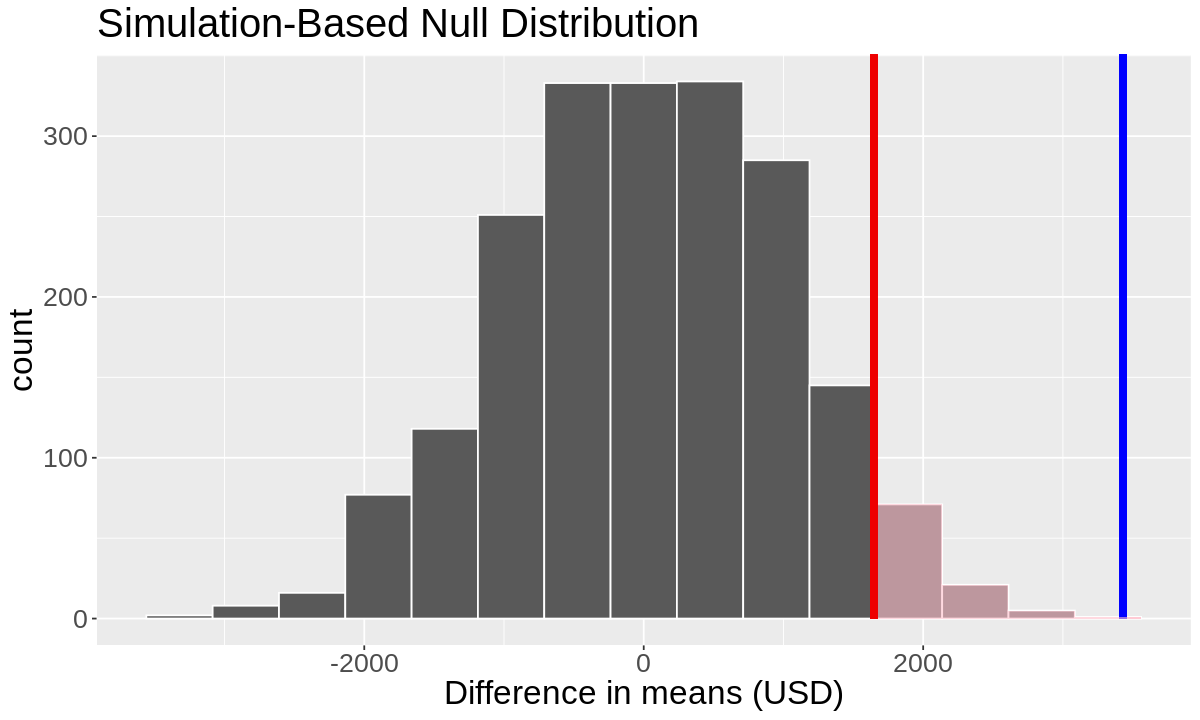

In [127]:
null_model_vis_infer <- diff_in_means |>
   visualize() + 
   shade_p_value(obs_stat = estimates$diff, direction = "right", color="blue") +
   shade_p_value(obs_stat = quantile975, direction = "right") +
   xlab("Difference in means (USD)") + 
   theme(text = element_text(size=20))

null_model_vis_infer

As the test statistic is well within the rejection zone, we will <mark>reject our null hypothesis</mark>. This also obeys our initial guess: it is much more expensive to attend school in a Democrat-leaning state.

__2.5.2 Bootstrapping Confidence Interval__

For a corresponding confidence interval of 95% with the infer workflow, we can exclude the hypothesize part and get the confidence intervals seamlessly.

In [86]:
set.seed(1)
diff_in_means_bootstrap <- tuition |>
    specify(mean_tuition_fees ~ political_leaning) %>% 
    generate(reps = 2000, type = "bootstrap") %>% 
    calculate(stat = "diff in means", order = c("demo", "repub")) 
    
diff_in_means_ci <- diff_in_means_bootstrap |>
    get_confidence_interval(level = 0.95, type = "percentile")

diff_in_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
1721.86,5260.025


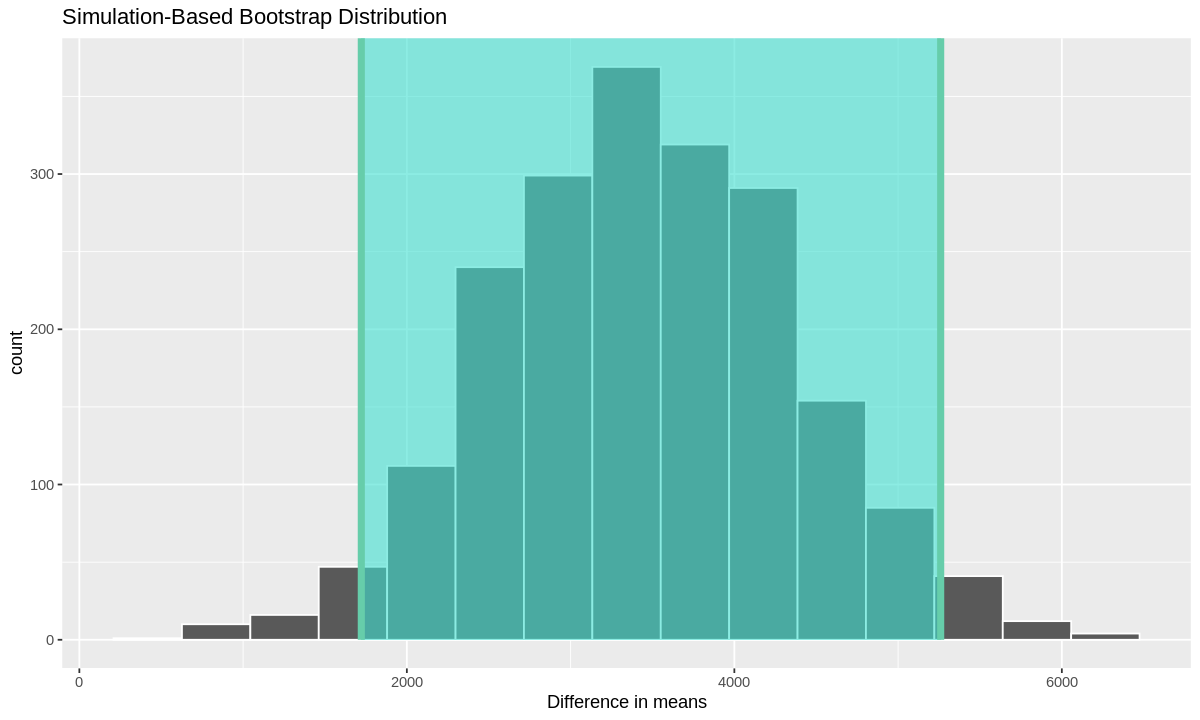

In [67]:
boot_ci <- diff_in_means_bootstrap |>
    visualize() +
    shade_confidence_interval(endpoints = diff_in_means_ci) +
    xlab("Difference in means")

boot_ci

According to this confidence interval, we are <mark>95% confident</mark> that the actual parameter of interest, $\mu_1 - \mu_2$, is <mark>between 1721.86 USD and 5260.025 USD</mark>.

Sampling variability introduced by the bootstrap method's random sampling may cause the confidence interval shown here to be wider than one produced via asymptotic hypothesis testing, since in asymptotic hypothesis testing the confidence interval is calculated based on a single sample and estimated standard error.

### 2.6 Confirming our results, one more time

Finally, we can use the function `t.test` in R to reconfirm all the above results.

Table 4: Summary details from `t.test`

In [ ]:
summary <- tidy(
    t.test(x = tuition |> filter(political_leaning == "demo") |> select(mean_tuition_fees),
           y = tuition |> filter(political_leaning == "repub") |> select(mean_tuition_fees),
           alternative = "two.sided",
           conf.level = 0.95))
summary

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
3431.759,17996.75,14564.99,3.746687,0.000506493,45.15059,1587.121,5276.397,Welch Two Sample t-test,two.sided


The p-value and confidence interval from both methods are <mark>approximately close to the built-in t.test function</mark>.

## __3. Discussion__

### 3.1 Hypothesis Testing Results
- Based on the results of our hypothesis test with a predetermined significance level of 0.05, we reject the null hypothesis that $H_0: \mu_1 - \mu_2 = 0$ in favor of the alternative hypothesis $H_1: \mu_1 - \mu_2 > 0$. The test statistic used was 3.74668744378548 with degrees of freedom 22. The p-value obtained was 0.00056, which is less than the predetermined significance level, indicating strong evidence against the null hypothesis. Therefore, we find that the tuition in Democratic states is more expensive than that in Republican states.

- Based on the bootstrap hypothesis test with null hypothesis $H_0: \mu_1 - \mu_2 = 0$ and alternative hypothesis $H_1: \mu_1 - \mu_2 > 0$, we saw that the observed test statistic is within the rejection zone of the bootstrap distribution. We thus reject the null hypothesis, much like the theory-based method above.

### 3.2 Confidence Interval Results

- Our theory-based confidence interval was (1532.206, 5331.313) at the 95% confidence level. This means that we are 95% confident that the true population parameter, the difference of Republican and Democratic tuition averages, is between that range. The positive range supports our initial hypothesis that schools in Democratic states are more expensive to attend.
- Our bootstrapping-based confidence interval was (1721.86, 5260.025) at the 95% confidence level. This suggests the same as the above; we are 95% confident the real population parameter lies within, and the positive range suggests Democratic schools charge higher tuition.

### 3.3 Method Evaluation
We tried both the theory-based and bootstrapping methods, but which method is better for this study?

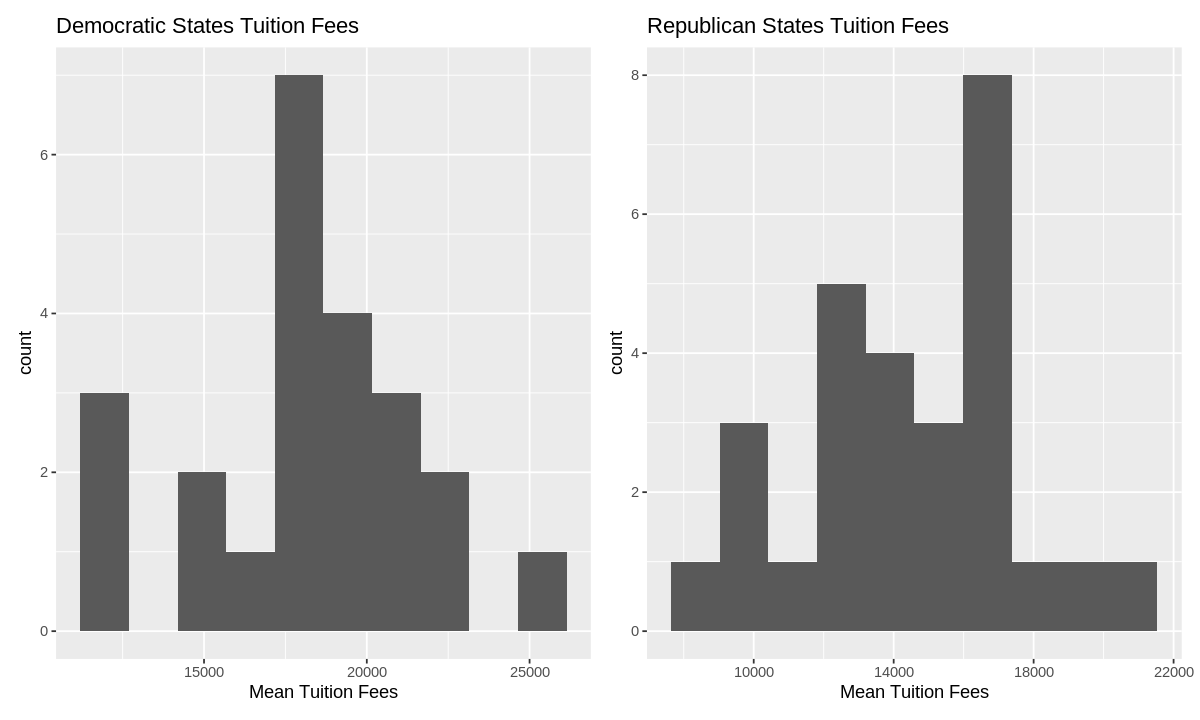

In [56]:
library(patchwork)

histogram1 <- tuition %>%
    filter(political_leaning == "demo") %>%
    ggplot() +
    geom_histogram(aes(x = mean_tuition_fees), bins = 10) +
    xlab("Mean Tuition Fees") +
    ggtitle("Democratic States Tuition Fees")

histogram2 <- tuition %>%
    filter(political_leaning == "repub") %>%
    ggplot() +
    geom_histogram(aes(x = mean_tuition_fees), bins = 10) +
    xlab("Mean Tuition Fees") +
    ggtitle("Republican States Tuition Fees")

# display histograms side by side
histogram1 + histogram2 + plot_layout(ncol = 2)

As we can see from the two histograms showing the original samples from each group, the distribution of Democratic States tuition fees is slightly skewed to the left and the distribution of Republican States tuition fees is also slightly skewed to the right. For this reason, we prefer the bootstrapping hypothesis testing method as it does not require us to make any assumptions about the distribution of the population.

### 3.4 Final Comments

__3.4.1 Findings__<br/>
From the theory-based hypothesis test, we rejected the null hypothesis by calculating p-value, which was much smaller than the stated significance level (0.05). We concluded that there is a significant difference between the average tuition cost in Republican-leaning states and Democrat-leaning states. By our bootstrapping hypothesis test, we obtained a 95% confidence interval without zero value inclusion, suggesting the average tuition in Democrat-leaning states is higher than Republican-leaning states. This is what we expected to find.

__3.4.2 Impact__<br/>
The findings of this investigation give many stakeholders who may be interested in the cost of tuition some reference. It is very meaningful to find a statistically significant difference in the population means for skeptical politicians, journalists or citizens that may be concerned about whether all the discussion in debates translates to real action and impact. This may motivate activists to re-evaluate their strategies, politicians to assess more impactful programs/policies, and corporations to increase lobbying efforts. In addition, the confidence interval describing the difference in tuition between Republican and Democrat states may better inform incoming students and their loved ones, who are concerned about finding education within their budget. They may make a good plan and preparation in advance based on the given data, so that they can receive education better. 

__3.4.3 Future Questions__<br/>
The findings of this study may contribute to identifying the true population means of the two parties' tuition costs, which may be useful for future statistical analyses. Namely, some further explorations may investigate the granular correlation between how Republican or Democrat-leaning a state is and what their tuition costs are; perhaps through a scatterplot and a correlation coefficient. Another related study may assess the correlation between public opinion and tuition costs, as a way of measuring the impact that citizens have on their tuition costs. Finally, the association between educational attainment and tuition costs in a state can also be tested to further measure the appropriateness of tuition cost setting.

## __4. References__

Chirumamilla, B. (2023, February 9). Average cost of undergraduate student by State USA. Kaggle. Retrieved March 18, 2023, from https://www.kaggle.com/datasets/bhargavchirumamilla/average-cost-of-undergraduate-student-by-state-usa

College Debt Essay Cover Photo. (n.d.). Berkeley Political Review. Retrieved March 18, 2023, from https://bpr.berkeley.edu/wp-content/uploads/2020/02/College-Debt-Essay-Cover-Photo-scaled.jpg.

Freedberg, L. (2020, June 16). Democrats and Republicans in Congress spar over need for more Federal Education Aid. EdSource. Retrieved March 18, 2023, from https://edsource.org/2020/democrats-and-republicans-in-congress-spar-over-need-for-more-federal-education-aid/633765 

Hartig, H. (2021, August 13). Democrats overwhelmingly favor free college tuition, while Republicans are divided by age, Education. Pew Research Center. Retrieved March 18, 2023, from https://www.pewresearch.org/fact-tank/2021/08/11/democrats-overwhelmingly-favor-free-college-tuition-while-republicans-are-divided-by-age-education/ 

The New York Times. (2020, November 3). Presidential election results: Biden wins. The New York Times. Retrieved March 18, 2023, from https://www.nytimes.com/interactive/2020/11/03/us/elections/results-president.html 